In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy import stats

In [2]:
from amb import *
palette_color = get_cell_class_palette()
palette_color['Sero'] = palette_color['Glut-Sero']

In [3]:
_gender = 'Male'
mc_type = 'CGN'
_type = 'DEG'
pvalue_cutoff = 0.05
fc_cutoff = 0.1

In [4]:
use_cts= joblib.load('mc_rna_corr_cts')
if mc_type == 'CHN':
    use_cts = [ct for ct in use_cts if ct.endswith('NN') == False]

In [5]:
_dir = '/home/qzeng/project/aging/240112_DMG_CEF'
mc_all = pd.read_csv(f'{_dir}/result/{_gender}.{mc_type}.DMG.csv', index_col = 0)
mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
gene_name_to_id = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [7]:
total_deg = []
total_dmg = []
rna_corr_dmg = []
result = {}

for ct in use_cts:
    rna_df = pd.read_csv(f"DEGs/{ct}.csv", index_col = 0)
    rna_df['log2(Aged/Young)'] = -rna_df['avg_log2FC']
    deg_df = rna_df[(rna_df['p_val_adj'] < pvalue_cutoff) & (abs(rna_df['log2(Aged/Young)']) > fc_cutoff)]
    total_deg.append(deg_df.shape[0])
    
    # get DEG mc info
    mc_df  = mc_all[mc_all['celltype'] == ct].copy()
    mc_df['gene_name'] = mc_df.index.map(gene_id_to_name)
    
    
    deg_mc_df = mc_df.set_index('gene_name')
    deg_mc_df  = deg_mc_df[deg_mc_df['pvalue'] < 0.05]
    total_dmg.append(deg_mc_df.shape[0])
    
    deg_mc_df = deg_mc_df.loc[deg_mc_df.index.isin(deg_df.index)]
    deg_mc_df['Aged-Young'] = deg_mc_df['18mo'] - deg_mc_df['8wk']
    # also filter for DMGs
    
    
    # filter duplicate genes
    unique_genes = deg_mc_df.index.value_counts()[deg_mc_df.index.value_counts() == 1].index
    deg_df = deg_df.loc[unique_genes]
    deg_mc_df = deg_mc_df.loc[unique_genes]
    
    to_plot = pd.concat([deg_df[['log2(Aged/Young)']], deg_mc_df[['Aged-Young']]], axis = 1)
    to_plot = to_plot.dropna()
    rna_corr_dmg.append(to_plot.shape[0])

In [8]:
result = pd.DataFrame({'total_deg':total_deg,'total_dmg':total_dmg,'rna_corr_dmg':rna_corr_dmg}, index =use_cts)
result['CellType'] = result.index
result['Class'] = result['CellType'].apply(lambda x: x.split('_')[-1])
result = result.sort_values('rna_corr_dmg', ascending = False)
result.head()

,total_deg,total_dmg,rna_corr_dmg,CellType,Class
DG_Glut,5400,25412,3868,DG_Glut,Glut
Oligo_NN,2969,16093,1262,Oligo_NN,NN
CA1-ProS_Glut,2043,16210,1246,CA1-ProS_Glut,Glut
STR_D1_Sema5a_Gaba,2015,19765,1058,STR_D1_Sema5a_Gaba,Gaba
L23_IT_CTX_Glut,2478,15721,896,L23_IT_CTX_Glut,Glut


In [9]:
result['rna_corr_dmg'].mean()

470.962962962963

In [10]:
# order by class
glut_cts = []
gaba_cts = []
nn_cts = []
for ct in result.index:
    if ct.endswith('Glut'):glut_cts.append(ct)
    elif ct.endswith('Gaba'):gaba_cts.append(ct)
    elif ct.endswith('NN'):nn_cts.append(ct)

new_order = nn_cts+ glut_cts + gaba_cts
result = result.loc[new_order]

In [11]:
result.groupby('Class')['rna_corr_dmg'].mean()

Class
Gaba    202.375000
Glut    651.857143
NN      394.200000
Name: rna_corr_dmg, dtype: float64

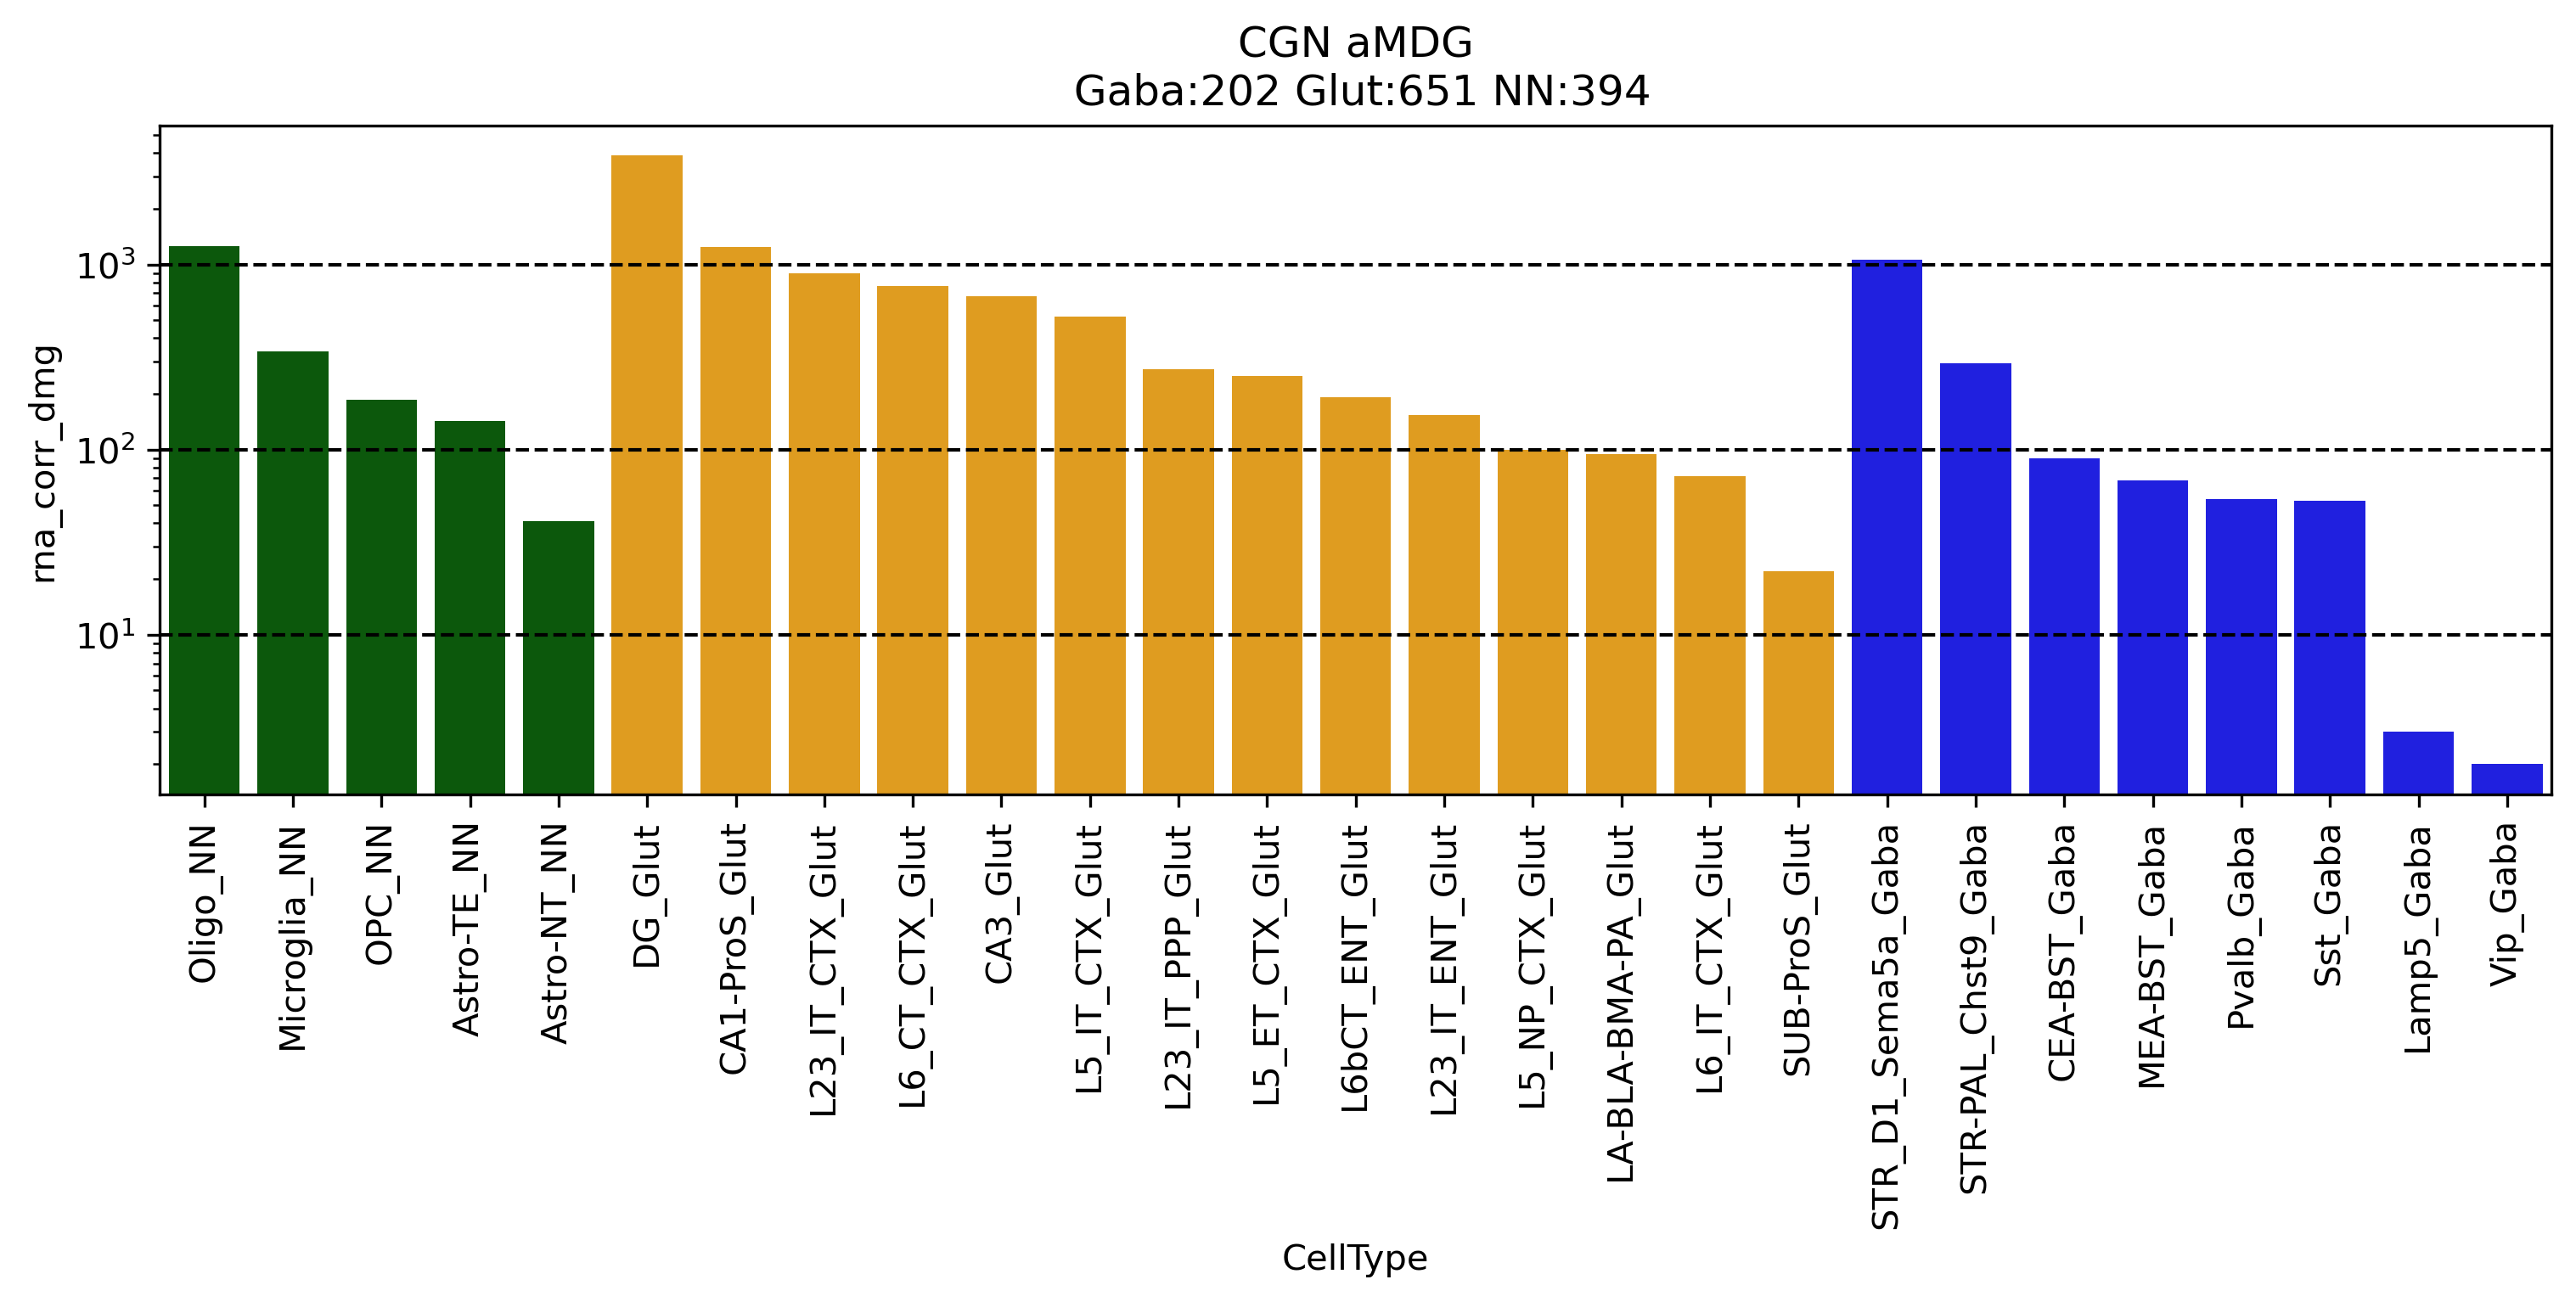

In [13]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300, constrained_layout = True)

sns.barplot(
            x=result["CellType"], 
            y=result['rna_corr_dmg'], 
            hue = result['Class'],
            palette = palette_color,
            ax = ax,
            dodge=False)
ax.axhline(y = 10, ls = '--', c = 'black', lw = 1)
ax.axhline(y = 100, ls = '--', c = 'black', lw = 1)
ax.axhline(y = 1000, ls = '--', c = 'black', lw = 1)
ax.set_yticks([10,100,1000])
ax.set_title(f'{mc_type} aMDG\n Gaba:202 Glut:651 NN:394')
ax.set_yscale('log')
ax.get_legend().remove()
plt.xticks(rotation=90)
fig.savefig(f"figure/{mc_type}.aDMG_number.pdf", bbox_inches = 'tight')
plt.show()